In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
#from functions import get_zone, load_360_data, get_progressive_actions, zone_polygon, plot_team_zone_shares, calc_width, calc_directness, calc_tempo, calc_possession_time
import functions
import plotting_func
import seaborn as sns
import pandas as pd

pd.set_option("display.float_format", "{:,.4f}".format)


### Features to use

Main tactical features to use:
- Width offensivly ✅
Average distance from center-line (goal-to-goal) where progressive actions end. 
- Directness ✅
Relationship of progressive actions to non progressive actions
- Tempo ✅
Velocity of ball, how fast do actions happen?
- Press height✅
How high up the field does the average pressure happen?
- Press intensity✅
How many pressing actions per minute of opposition possession
- Pass length

- Restförsvar ?
- Fasta situationer ?

- Höjd på backlinje
- Antal progressiva passningar

- Bollhastighet
- Final third entries

### Game State:
- Which zone are we in?
- Distance to goal?
- Angle to goal?
- Opponents near?
- How many opponants near?
- Score?
-  Red cards?

### Tactics: 


In [2]:
actions=("Pass", "Carry", "Dribble")
action_types_exclude = ["Throw-in", "Corner", "Free Kick", "Kick-off", "Goal Kick"]
df = functions.load_360_data(actions, three_sixty_only=True)

print("data loaded")

#is_dead_ball_action = df["pass_type"].isin(action_types_exclude)


actions = functions.get_progressive_actions(df=df)
prog_passes = actions[actions["is_progressive"] == False]



Loading events: 100%|██████████| 326/326 [00:15<00:00, 21.51it/s]


data loaded


In [7]:
def calc_pass_length(
    df: pd.DataFrame,
    match: bool = True,
    exclude_restarts: bool = True,
) -> pd.DataFrame:
    """
    Pass length features (mean + std) using StatsBomb 'pass_length' extracted at load time.

    Required columns:
      - match_id
      - team_id
      - type == "Pass"
      - pass_length
    Optional:
      - pass_subtype (for excluding restarts)

    Returns:
      match=True: match_id, team_id, n_passes, mean_pass_length, std_pass_length
      match=False: team_id, n_passes, mean_pass_length, std_pass_length
    """
    df = df.copy()

    if "match_id" in df.columns:
        df["match_id"] = df["match_id"].astype("Int64")
    if "team_id" in df.columns:
        df["team_id"] = df["team_id"].astype("Int64")

    passes = df[(df["type"] == "Pass") & (df["pass_length"].notna())].copy()

    if exclude_restarts and "pass_subtype" in passes.columns:
        exclude = {"Corner", "Free Kick", "Throw-in", "Goal Kick", "Kick Off"}
        passes = passes[~passes["pass_subtype"].isin(exclude)].copy()

    grp = ["match_id", "team_id"] if match else ["team_id"]

    out = (
        passes.groupby(grp)
              .agg(
                  n_passes=("pass_length", "size"),
                  mean_pass_length=("pass_length", "mean"),
                  std_pass_length=("pass_length", "std"),
              )
              .reset_index()
    )

    out["team_id"] = out["team_id"].astype("Int64")
    return out


In [8]:
pass_df = calc_pass_length(df, match=True)
# Longest average pass match
row_long = pass_df.loc[pass_df["mean_pass_length"].idxmax()]

# Shortest average pass match
row_short = pass_df.loc[pass_df["mean_pass_length"].idxmin()]

print("Longest passes:\n", row_long)
print("\nShortest passes:\n", row_short)


Longest passes:
 match_id           3,930,184.0000
team_id                  912.0000
n_passes                 222.0000
mean_pass_length          27.5603
std_pass_length           16.9737
Name: 541, dtype: Float64

Shortest passes:
 match_id           3,895,158.0000
team_id                  904.0000
n_passes                 672.0000
mean_pass_length          15.7047
std_pass_length            9.6207
Name: 413, dtype: Float64


In [13]:
def get_pass_lengths(df, row):
    sub = df[
        (df["match_id"] == row["match_id"]) &
        (df["team_id"] == row["team_id"]) &
        (df["type"] == "Pass") &
        (df["x"].notna()) &
        (df["y"].notna()) &
        (df["endx"].notna()) &
        (df["endy"].notna())
    ].copy()

    sub["pass_length"] = np.sqrt(
        (sub["endx"] - sub["x"])**2 +
        (sub["endy"] - sub["y"])**2
    )
    return sub["pass_length"].values

def plot_pass_length_histograms(df, row_long, row_short, bins=25):
    

    lengths_long = get_pass_lengths(df, row_long)
    lengths_short = get_pass_lengths(df, row_short)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Longest mean
    axes[0].hist(lengths_long, bins=bins, density=True)
    axes[0].axvline(row_long["mean_pass_length"], linestyle="--")
    axes[0].set_title(
        f"Longest passes\nMean={row_long['mean_pass_length']:.1f}, Std={row_long['std_pass_length']:.1f}"
    )
    axes[0].set_xlabel("Pass length (m)")

    # Shortest mean
    axes[1].hist(lengths_short, bins=bins, density=True)
    axes[1].axvline(row_short["mean_pass_length"], linestyle="--")
    axes[1].set_title(
        f"Shortest passes\nMean={row_short['mean_pass_length']:.1f}, Std={row_short['std_pass_length']:.1f}"
    )
    axes[1].set_xlabel("Pass length (m)")

    axes[0].set_ylabel("Density")

    fig.suptitle("Pass Length Distribution Comparison")
    plt.tight_layout()
    plt.show()


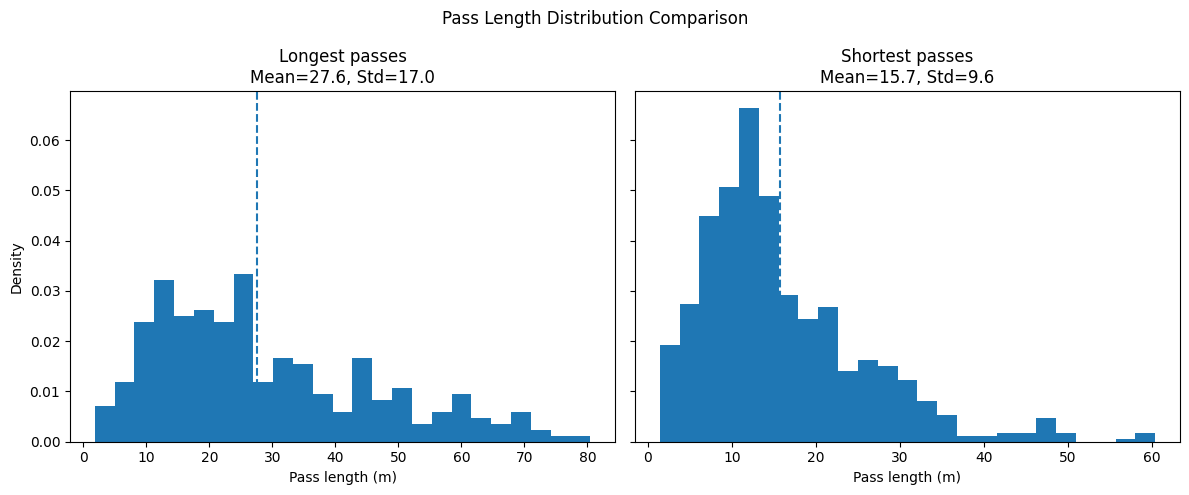

In [17]:
plot_pass_length_histograms(df, row_long, row_short)


In [18]:
lengths_long = get_pass_lengths(df, row_long)
lengths_short = get_pass_lengths(df, row_short)

print("Longest passes percentiles:")
print(np.percentile(lengths_long, [50, 75, 90, 95, 99]))
print("Shortest passes percentiles:")
print(np.percentile(lengths_short, [50, 75, 90, 95, 99]))


Longest passes percentiles:
[25.09611424 39.85527406 56.64801602 62.46058157 72.09236702]
Shortest passes percentiles:
[13.39589489 20.77919486 29.55320388 34.17360662 48.30662914]
